In [1]:
import sys
sys.path.append('../../')

from tqdm import tqdm

import xarray as xr
import pandas as pd
import numpy as np
import torch as tc

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from rcgp.rcgp import SpatioTemporalRCGP 

from BayesNewton.bayesnewton.utils import create_spatiotemporal_grid

FILE_PATH = '../../data/cru_ts4.08.2021.2023.tmp.dat.nc'

LAT_MIN, LAT_MAX = 30, 60
LON_MIN, LON_MAX = -11, 19.5

LAT_MIN, LAT_MAX = 45, 60
LON_MIN, LON_MAX = -12, 8

plt.rc('font', family='serif', size=14)

In [3]:
def compute_nlpd(y_true, mu_pred, sigma_pred):

    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    mu_pred = np.array(mu_pred)
    sigma_pred = np.array(sigma_pred)
    
    # Avoid division by zero or invalid log by adding a small epsilon to sigma
    epsilon = 1e-8
    sigma_pred = np.maximum(sigma_pred, epsilon)
    
    # Compute log predictive density for Gaussian
    log_pdf = -0.5 * np.log(2 * np.pi * sigma_pred**2) - ((y_true - mu_pred)**2 / (2 * sigma_pred**2))
    
    # Compute and return the NLPD
    nlpd = -np.mean(log_pdf)
    return nlpd

def compute_rmse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    if len(y_true) != len(y_pred):
        raise ValueError("The lengths of y_true and y_pred must be the same.")
    
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

In [180]:
def plot_temperature_map(data, vmin, vmax, lat_col='lat', lon_col='lon', pred_col='pred',
                                    cmap='plasma', figsize=(6,6), outliers_plot=True):

    plt.rc('font', family='serif', size=13)
    # Extract data
    lat = data[lat_col].values
    lon = data[lon_col].values
    pred = data[pred_col].values

    # Calculate approximate resolution based on unique lat/lon spacing
    lat_spacing = np.median(np.diff(np.unique(lat)))
    lon_spacing = np.median(np.diff(np.unique(lon)))

    # Create a grid with dynamic resolution
    lat_min, lat_max = lat.min(), lat.max()
    lon_min, lon_max = lon.min(), lon.max()
    lat_grid = np.arange(lat_min, lat_max + lat_spacing, lat_spacing)
    lon_grid = np.arange(lon_min, lon_max + lon_spacing, lon_spacing)
    lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

    # Initialize a grid for temperatures with NaN values
    grid_pred = np.full(lon_grid.shape, np.nan)

    # Map data points to the grid
    for i in range(len(lat)):
        # Find the nearest grid points for each data point
        row = np.abs(lat_grid[:, 0] - lat[i]).argmin()
        col = np.abs(lon_grid[0, :] - lon[i]).argmin()
        grid_pred[row, col] = pred[i]

    # Mask NaN values
    grid_pred_masked = np.ma.masked_invalid(grid_pred)

    # Create the Basemap
    plt.figure(figsize=figsize)
    m = Basemap(projection='merc',
                llcrnrlat=lat_min, urcrnrlat=lat_max,
                llcrnrlon=lon_min, urcrnrlon=lon_max,
                resolution='i')

    # Draw map features
    m.drawcoastlines()
    m.drawcountries()
    m.drawparallels(np.arange(-90, 90, 5), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180, 180, 5), labels=[0, 0, 0, 1])

    # Convert grid coordinates to map projection
    x, y = m(lon_grid, lat_grid)

    # Plot the masked temperature grid

    if outliers_plot:
        levels = np.append(np.linspace(vmin, vmax, 15), [100,150])  # Levels within the main range
    else: 
        levels = np.linspace(vmin, vmax, 15)  # Levels within the main range


    if not outliers_plot:
        cmap = plt.get_cmap(cmap)
        cmap.set_over('red')

    contour = m.contourf(x, y, grid_pred_masked, cmap=cmap, vmin=vmin, vmax=vmax, levels=levels, extend='max')
    cbar = plt.colorbar(contour, label='Temperature (°C)')

    if outliers_plot:
        outliers = data[(data[pred_col] < vmin) | (data[pred_col] > vmax)]
        x_outliers, y_outliers = m(outliers["lon"].values, outliers["lat"].values)
        m.scatter(x_outliers, y_outliers, marker='x', s=50, color='red')


    # Add a title and show the plot
    #plt.title('Temperature (°C) on December 16th 2023')
    #plt.savefig("plots/weather-data-one-month-pred-spatio-temporal.pdf", format='pdf', bbox_inches='tight')

    plt.show()

### Experiment

We train on data until last three time steps (stop at idx=-3, not including it). 

At -3, regular data, and show that both are the same RMSE/NLPD-wise. 

At the -2 step, there is a region with outliers (broken sensor). We perform predict/update on -2, showing that ST-RCGP is better than regular STGP at handling the outliers when filtering using RMSE/NLPD with actual data. 

Finally we show at -1 that the prediction (only predict step) is better again. 


Overall, we will have shown that once both models are trained, the ST-RCGP is just as fast as STGP, produces identical results when there are no outliers, but is more reliable in filtering and predicting when there are outliers.

In [142]:
dataset = xr.open_dataset(FILE_PATH)
data_var = dataset['tmp']
df = data_var.to_dataframe().reset_index().dropna()

#restricting longitude and latitude to desired area
df = df[(df['lat'] > LAT_MIN) & (df['lat'] < LAT_MAX) & (df['lon'] > LON_MIN) & (df['lon'] < LON_MAX)]

#restricting time steps to desired time span
df = df[df['time'] > '2022-01-01'].reset_index(drop=True)
time_numeric = df['time'].astype(int)
time_numeric = (time_numeric - time_numeric.min())/ (time_numeric.max() - time_numeric.min()) * 24
df['time_numeric'] = time_numeric

#Splitting into train/test
test_idx = df.time.isin(df.time.unique()[-3:])
df_test = df[test_idx].copy()
df_train = df[~test_idx].copy()

#Adding Outliers in -2 idx to test data
np.random.seed(0)
outlier_idx_block = (df_test.time==df_test.time.unique()[-2]) & (df_test['lat'] > 51.25) & (df_test['lat'] < 53.25) & (df_test['lon'] > -3) & (df_test['lon'] < -1)
outlier_idx = np.random.choice(df_test.index[outlier_idx_block], size=int(0.5 * len(df_test.index[outlier_idx_block])), replace=False)

df_test.loc[:, "tmp_data"]= df_test.loc[:, "tmp"].copy()
df_test.loc[outlier_idx, "tmp_data"] = np.random.normal(120, scale=10, size=len(outlier_idx)).astype(np.float32)

#Replacing tmp values with NaNs so that we predict
df_test.loc[df_test.time==df_test.time.unique()[-1], "tmp_data"] = np.nan

#pre-processing
df_train.loc[:, 'lat_norm'] = (df_train['lat'] - df_train['lat'].mean())/df_train['lat'].std()
df_train.loc[:, 'lon_norm'] = (df_train['lon'] - df_train['lon'].mean())/df_train['lon'].std()
df_train.loc[:, 'tmp_norm'] = (df_train['tmp'] - df_train['tmp'].mean())/df_train['tmp'].std()

#Using train data to pre-process test data
df_test.loc[:, 'lat_norm'] = (df_test['lat'] - df_train['lat'].mean())/df_train['lat'].std()
df_test.loc[:, 'lon_norm'] = (df_test['lon'] - df_train['lon'].mean())/df_train['lon'].std()
df_test.loc[:, 'tmp_norm_data'] = (df_test['tmp_data'] - df_train['tmp'].mean())/df_train['tmp'].std()

In [68]:
X_train, X_test = df_train[['time_numeric', 'lat_norm', 'lon_norm']].to_numpy(), df_test[['time_numeric', 'lat_norm', 'lon_norm']].to_numpy()
Y_train, Y_test = df_train["tmp_norm"].to_numpy().reshape(-1,1), df_test["tmp_norm_data"].to_numpy().reshape(-1,1)

ts_train, R, Ys_train = create_spatiotemporal_grid(X_train, Y_train)
ts_test, _, Ys_test = create_spatiotemporal_grid(X_test, Y_test)

ts_train = tc.from_numpy(np.array(ts_train)).float()
ts_test = tc.from_numpy(np.array(ts_test)).float()

grid = tc.from_numpy(np.array(R)[0]).float()

Ys_train = tc.from_numpy(np.array(Ys_train)).float()
Ys_test = tc.from_numpy(np.array(Ys_test)).float()



n_lat = len(df.lat.unique())
n_lon = len(df.lon.unique())
n_t = len(df.time.unique())

print("Start Date, End Date: ", df.time.unique()[0], ", ", df.time.unique()[-2])
print("Number of Time Steps : ", n_t)
print("Number of Spatio-Temporal inputs (lon,lat) : ", len(R[0]))
print("Number of Training Points : ", len(Ys_train.flatten()))
print("Number of outliers : ", len(outlier_idx))

Start Date, End Date:  2022-01-16 00:00:00 ,  2023-11-16 00:00:00
Number of Time Steps :  24
Number of Spatio-Temporal inputs (lon,lat) :  571
Number of Training Points :  11991
Number of outliers :  12


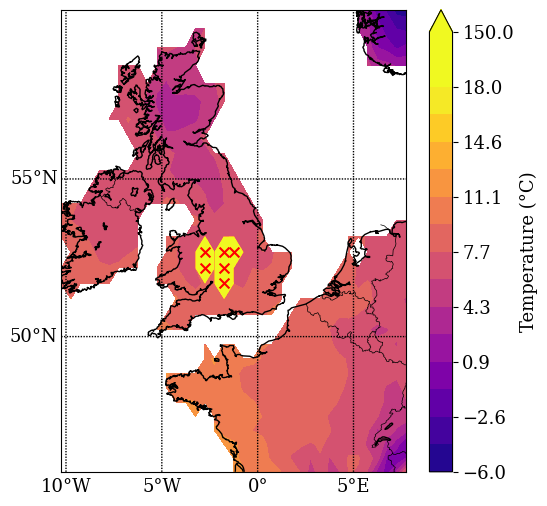

In [181]:
plot_temperature_map(df_test[df_test.time==df_test.time.unique()[-2]], vmin=-6, vmax=18, pred_col="tmp_data", outliers_plot=True)

### Optimizing Parameters

In [182]:
optim=False

In [70]:
def scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor):

    S = covs + R + 1e-4 * tc.eye(len(R))
    eps = Ys - preds

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)
    
    return energies.sum()

In [183]:
if optim:
    STGP = SpatioTemporalRCGP(ts=ts_train, grid=grid, Ys=Ys_train, p=1)
    STGP.deactivate_robustness()

    losses = []
    n_steps = 40
    lr = 0.02

    STGP.var_y = 0.3
    STGP._raw_var_y.requires_grad = False


    optimizer = tc.optim.Adam(STGP.parameters(), lr=lr)

    for step in tqdm(range(n_steps)):
        _,(preds, covs, R, Ws), _ = STGP.forward(smoothing=False)

        loss = scoring_rule(Ys=Ys_train, preds=preds, covs=covs, R=R)
        loss.backward()
        losses.append(loss.clone().detach())
        #print("Loss : ", loss.clone().detach())
        
        optimizer.step()  # Update parameters
        optimizer.zero_grad()  # Reset gradients

    plt.figure(figsize=(8,2))
    plt.plot(losses)
    plt.ylabel("Loss")
    plt.xlabel("Optimisation Step");

    print("var : ", STGP.var_y.item())
    print("temp lengthscale : ", STGP.temporal_lengthscale.item())
    print("temp magnitude : ", STGP.temporal_magnitude.item())
    print("spatial lengthscale : ", STGP.spatial_lengthscale.item())
    print("spatial magnitude : ", STGP.spatial_magnitude.item())

    pd.Series({"var" : STGP.var_y.item(), "tl" : STGP.temporal_lengthscale.item(), "tm": STGP.temporal_magnitude.item(), "sl" : STGP.spatial_lengthscale.item(), "sm" : STGP.spatial_magnitude.item()}).to_csv("./STGP_params.csv")



In [184]:
if optim:
    RCGP = SpatioTemporalRCGP(ts=ts_train, grid=grid, Ys=Ys_train, p=1)
    RCGP.activate_robustness("m_pred")
    RCGP.adaptive_c()

    losses = []
    n_steps = 40
    lr = 0.02

    RCGP.var_y = 0.3
    RCGP._raw_var_y.requires_grad = False


    optimizer = tc.optim.Adam(RCGP.parameters(), lr=lr)

    for step in tqdm(range(n_steps)):
        _,(preds, covs, R, Ws), _ = RCGP.forward(smoothing=False)

        loss = scoring_rule(Ys=Ys_train, preds=preds, covs=covs, R=R)
        loss.backward()
        losses.append(loss.clone().detach())
        #print("Loss : ", loss.clone().detach())
        
        optimizer.step()  # Update parameters
        optimizer.zero_grad()  # Reset gradients

    plt.figure(figsize=(8,2))
    plt.plot(losses)
    plt.ylabel("Loss")
    plt.xlabel("Optimisation Step");

    print("var : ", RCGP.var_y.item())
    print("temp lengthscale : ", RCGP.temporal_lengthscale.item())
    print("temp magnitude : ",RCGP.temporal_magnitude.item())
    print("spatial lengthscale : ", RCGP.spatial_lengthscale.item())
    print("spatial magnitude : ", RCGP.spatial_magnitude.item())

    pd.Series({"var" : RCGP.var_y.item(), "tl" : RCGP.temporal_lengthscale.item(), "tm": RCGP.temporal_magnitude.item(), "sl" : RCGP.spatial_lengthscale.item(), "sm" : RCGP.spatial_magnitude.item()}).to_csv("./RCGP_params.csv")

## Inference - STGP

In [185]:
ts, Ys = tc.concat([ts_train, ts_test]), tc.concat([Ys_train, Ys_test])

In [186]:
def get_rmse_nlpd(preds_smooth, stds_smooth):

    for i in [-6,-5,-4]:
        #Last Training Month
        df_stgp_train_month = pd.DataFrame(tc.hstack([grid, preds_smooth[i].reshape(-1,1)]), columns=["lat", "lon", "pred"])

        df_stgp_train_month['lon'] = df_stgp_train_month['lon'] * df_train['lon'].std() +  df_train['lon'].mean()
        df_stgp_train_month['lat'] = df_stgp_train_month['lat'] *  df_train['lat'].std() +  df_train['lat'].mean()
        df_stgp_train_month['pred'] = df_stgp_train_month['pred'] *  df_train['tmp'].std() +  df_train['tmp'].mean()
        df_stgp_train_month["std"] = stds_smooth[i].flatten() *  df_train["tmp"].std()

        y_true = df_train[df_train.time==df_train.time.unique()[i+3]].tmp.to_numpy()
        y_pred = df_stgp_train_month["pred"]
        pred_std = df_stgp_train_month["std"]

        if i==-4:
            print("Regular Month (Last Training Step) : ")
        else:
            print("Regular Month : ")
        print("NLPD : ", compute_nlpd(y_true, mu_pred=y_pred, sigma_pred=pred_std))
        print("RMSE : ", compute_rmse(y_true=y_true, y_pred=y_pred))

    df_stgp_reg_month = pd.DataFrame(tc.hstack([grid, preds_smooth[-3].reshape(-1,1)]), columns=["lat", "lon", "pred"])

    df_stgp_reg_month['lon'] = df_stgp_reg_month['lon'] * df_train['lon'].std() +  df_train['lon'].mean()
    df_stgp_reg_month['lat'] = df_stgp_reg_month['lat'] *  df_train['lat'].std() +  df_train['lat'].mean()
    df_stgp_reg_month['pred'] = df_stgp_reg_month['pred'] *  df_train['tmp'].std() +  df_train['tmp'].mean()
    df_stgp_reg_month["std"] = stds_smooth[-3].flatten() *  df_train["tmp"].std()

    y_true = df_test[df_test.time==df_test.time.unique()[-3]].tmp_data.to_numpy()
    y_pred = df_stgp_reg_month["pred"]
    pred_std = df_stgp_reg_month["std"]
    print("Regular Month : ")
    print("NLPD : ", compute_nlpd(y_true, mu_pred=y_pred, sigma_pred=pred_std))
    print("RMSE : ", compute_rmse(y_true=y_true, y_pred=y_pred))

    df_stgp_outlier_month = pd.DataFrame(tc.hstack([grid, preds_smooth[-2].reshape(-1,1)]), columns=["lat", "lon", "pred"])

    df_stgp_outlier_month['lon'] = df_stgp_outlier_month['lon'] * df_train['lon'].std() +  df_train['lon'].mean()
    df_stgp_outlier_month['lat'] = df_stgp_outlier_month['lat'] *  df_train['lat'].std() +  df_train['lat'].mean()
    df_stgp_outlier_month['pred'] = df_stgp_outlier_month['pred'] *  df_train['tmp'].std() +  df_train['tmp'].mean()
    df_stgp_outlier_month["std"] = stds_smooth[-2].flatten() *  df_train["tmp"].std()

    y_true = df_test[df_test.time==df_test.time.unique()[-2]].tmp.to_numpy()
    y_pred = df_stgp_outlier_month["pred"]
    pred_std = df_stgp_outlier_month["std"]

    print("Outlier Month : ")
    print("NLPD : ", compute_nlpd(y_true, mu_pred=y_pred, sigma_pred=pred_std))
    print("RMSE : ", compute_rmse(y_true=y_true, y_pred=y_pred))

    df_stgp_last_month = pd.DataFrame(tc.hstack([grid, preds_smooth[-1].reshape(-1,1)]), columns=["lat", "lon", "pred"])

    df_stgp_last_month['lon'] = df_stgp_last_month['lon'] * df_train['lon'].std() +  df_train['lon'].mean()
    df_stgp_last_month['lat'] = df_stgp_last_month['lat'] *  df_train['lat'].std() +  df_train['lat'].mean()
    df_stgp_last_month['pred'] = df_stgp_last_month['pred'] *  df_train['tmp'].std() +  df_train['tmp'].mean()
    df_stgp_last_month["std"] = stds_smooth[-1].flatten() *  df_train["tmp"].std()

    y_true = df_test[df_test.time==df_test.time.unique()[-3]].tmp_data.to_numpy()
    y_pred = df_stgp_last_month["pred"]
    pred_std = df_stgp_last_month["std"]

    print("Prediction Month : ")
    print("NLPD : ", compute_nlpd(y_true, mu_pred=y_pred, sigma_pred=pred_std))
    print("RMSE : ", compute_rmse(y_true=y_true, y_pred=y_pred))
    
    return df_stgp_train_month, df_stgp_reg_month, df_stgp_outlier_month, df_stgp_last_month

In [77]:
"""stgp_base_model0 = SpatioTemporalRCGP(ts=ts_train, grid=grid, Ys=Ys_train, p=1)

params = pd.read_csv("STGP_params.csv", index_col=0)
#Hyperparameters
var_y = 1.
magnitude_space=1.
magnitude_time=0.1
lengthscale_space=0.7
lengthscale_time=0.5

stgp_base_model0.var_y = var_y
stgp_base_model0.temporal_lengthscale = lengthscale_time
stgp_base_model0.temporal_magnitude = magnitude_time
stgp_base_model0.spatial_lengthscale = lengthscale_space
stgp_base_model0.spatial_magnitude = magnitude_space


with tc.no_grad():
    (preds_smooth_stgp0, stds_smooth_stgp0, eff_stgp0), (preds_filt_stgp0, covs_filt_stgp0, R_stgp0, Ws_norm_stgp0), (ms_stgp0, Ps_stgp0) = stgp_base_model0.forward(smoothing=True)


print("var : ", stgp_base_model0.var_y.item())
print("temp lengthscale : ", stgp_base_model0.temporal_lengthscale.item())
print("temp magnitude : ", stgp_base_model0.temporal_magnitude.item())
print("spatial lengthscale : ", stgp_base_model0.spatial_lengthscale.item())
print("spatial magnitude : ", stgp_base_model0.spatial_magnitude.item())"""

'stgp_base_model0 = SpatioTemporalRCGP(ts=ts_train, grid=grid, Ys=Ys_train, p=1)\n\nparams = pd.read_csv("STGP_params.csv", index_col=0)\n#Hyperparameters\nvar_y = 1.\nmagnitude_space=1.\nmagnitude_time=0.1\nlengthscale_space=0.7\nlengthscale_time=0.5\n\nstgp_base_model0.var_y = var_y\nstgp_base_model0.temporal_lengthscale = lengthscale_time\nstgp_base_model0.temporal_magnitude = magnitude_time\nstgp_base_model0.spatial_lengthscale = lengthscale_space\nstgp_base_model0.spatial_magnitude = magnitude_space\n\n\nwith tc.no_grad():\n    (preds_smooth_stgp0, stds_smooth_stgp0, eff_stgp0), (preds_filt_stgp0, covs_filt_stgp0, R_stgp0, Ws_norm_stgp0), (ms_stgp0, Ps_stgp0) = stgp_base_model0.forward(smoothing=True)\n\n\nprint("var : ", stgp_base_model0.var_y.item())\nprint("temp lengthscale : ", stgp_base_model0.temporal_lengthscale.item())\nprint("temp magnitude : ", stgp_base_model0.temporal_magnitude.item())\nprint("spatial lengthscale : ", stgp_base_model0.spatial_lengthscale.item())\nprint

In [78]:
"""scoring_rule(Ys=Ys_train, preds=preds_filt_stgp0, covs=covs_filt_stgp0, R=R_stgp0)"""

'scoring_rule(Ys=Ys_train, preds=preds_filt_stgp0, covs=covs_filt_stgp0, R=R_stgp0)'

In [79]:
"""df_stgp0_reg_month, df_stgp0_outlier_month, df_stgp0_last_month = get_rmse_nlpd(preds_smooth=preds_smooth_stgp0, stds_smooth=stds_smooth_stgp0)"""

'df_stgp0_reg_month, df_stgp0_outlier_month, df_stgp0_last_month = get_rmse_nlpd(preds_smooth=preds_smooth_stgp0, stds_smooth=stds_smooth_stgp0)'

In [80]:
"""for i in range(10):
    plt.plot(preds_smooth_stgp0[:, 4 * i])
    plt.plot(Ys_train[:, 4 * i], '--')"""

"for i in range(10):\n    plt.plot(preds_smooth_stgp0[:, 4 * i])\n    plt.plot(Ys_train[:, 4 * i], '--')"

In [187]:
stgp_base_model = SpatioTemporalRCGP(ts=ts, grid=grid, Ys=Ys, p=1)

params = pd.read_csv("STGP_params.csv", index_col=0)

stgp_base_model.var_y = params.loc["var"].item()
stgp_base_model.temporal_lengthscale = params.loc["tl"].item()
stgp_base_model.temporal_magnitude = params.loc["tm"].item()
stgp_base_model.spatial_lengthscale = params.loc["sl"].item()
stgp_base_model.spatial_magnitude = params.loc["sm"].item()

with tc.no_grad():
    (preds_smooth_stgp, stds_smooth_stgp, eff_stgp), (preds_filt_stgp, covs_filt_stgp, R_stgp, Ws_norm_stgp), (ms_stgp, Ps_stgp) = stgp_base_model.forward(smoothing=True)


print("var : ", stgp_base_model.var_y.item())
print("temp lengthscale : ", stgp_base_model.temporal_lengthscale.item())
print("temp magnitude : ", stgp_base_model.temporal_magnitude.item())
print("spatial lengthscale : ", stgp_base_model.spatial_lengthscale.item())
print("spatial magnitude : ", stgp_base_model.spatial_magnitude.item())


var :  0.2999999523162842
temp lengthscale :  1.861838698387146
temp magnitude :  0.8482528328895569
spatial lengthscale :  1.843935251235962
spatial magnitude :  0.8482528328895569


In [188]:
df_stgp_train_month, df_stgp_reg_month, df_stgp_outlier_month, df_stgp_last_month = get_rmse_nlpd(preds_smooth=preds_smooth_stgp, stds_smooth=stds_smooth_stgp)

Regular Month : 
NLPD :  1.0203892
RMSE :  0.7506398
Regular Month : 
NLPD :  1.0585873
RMSE :  0.7601429
Regular Month (Last Training Step) : 
NLPD :  1.4070143
RMSE :  0.87525696
Regular Month : 
NLPD :  6.6334786
RMSE :  1.9049914
Outlier Month : 
NLPD :  85.92121
RMSE :  7.1464233
Prediction Month : 
NLPD :  4.9198723
RMSE :  7.2676167


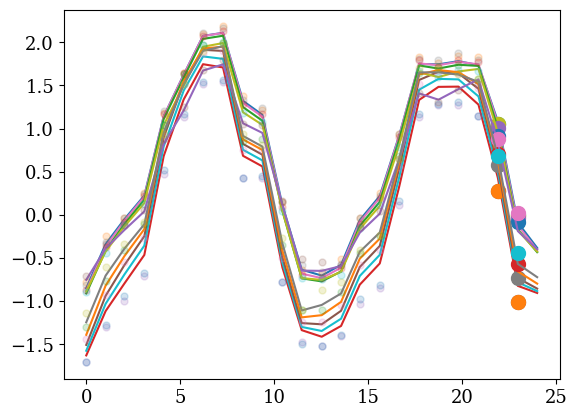

In [189]:
for i in range(10):
    plt.plot(ts, preds_smooth_stgp[:, 10 * i], label="Pred")
    plt.plot(ts_train, Ys_train[:, 10 * i], '.', alpha=0.2, markersize=10, label="Train data")
    plt.plot(ts_test, Ys_test[:, 10 * i], '.', markersize=20, label="Test data")

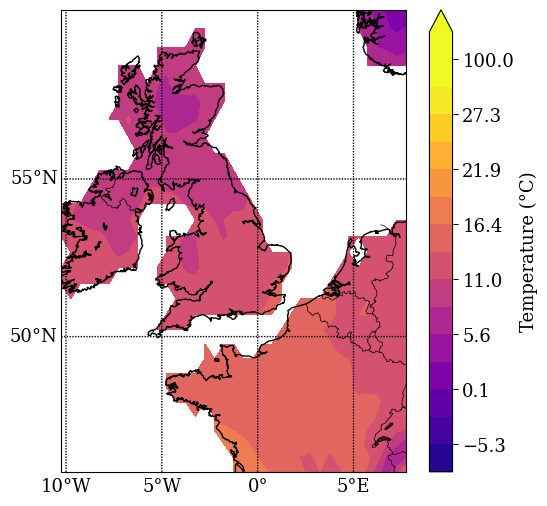

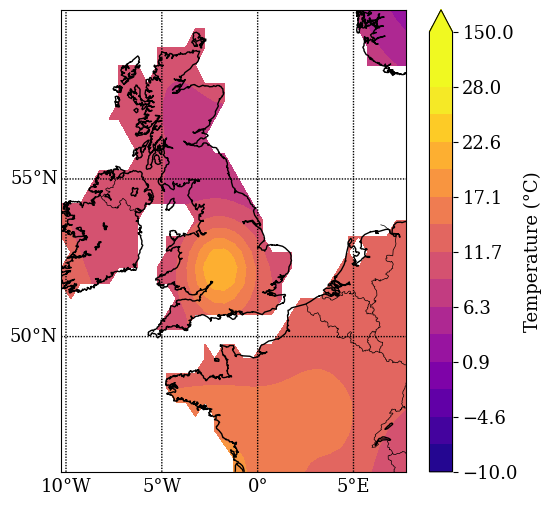

In [196]:
plot_temperature_map(df_test[df_test.time==df_test.time.unique()[-3]], vmin=-8, vmax=30, pred_col="tmp_data")
plot_temperature_map(df_stgp_reg_month, vmin=-10, vmax=28, pred_col="pred")

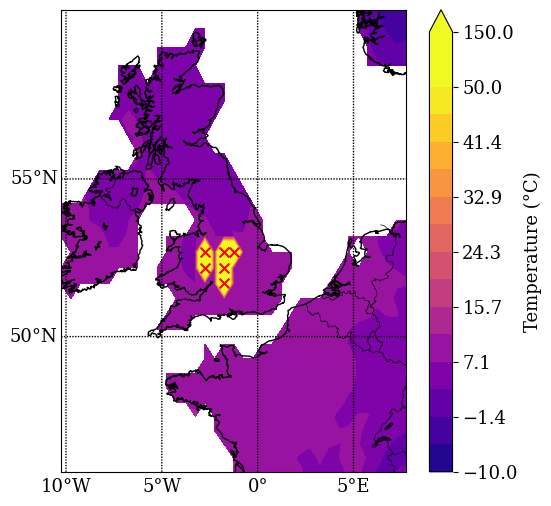

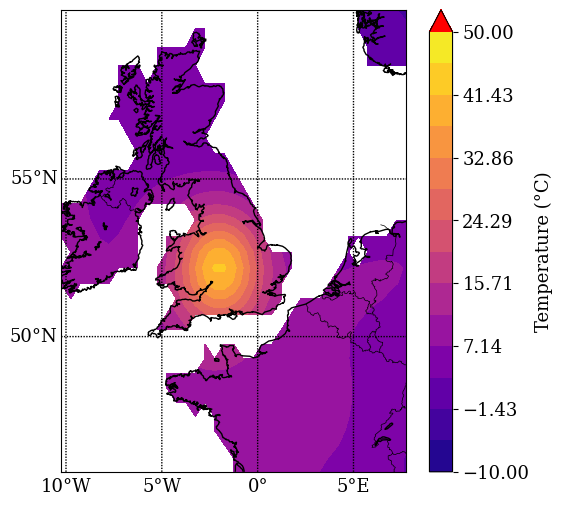

In [195]:
plot_temperature_map(df_test[df_test.time==df_test.time.unique()[-2]], vmin=-10, vmax=50, pred_col="tmp_data")
plot_temperature_map(df_stgp_outlier_month, vmin=-10, vmax=50, pred_col="pred", outliers_plot=False)

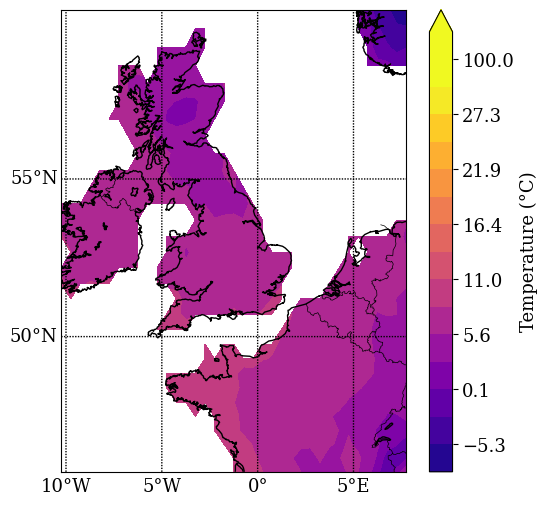

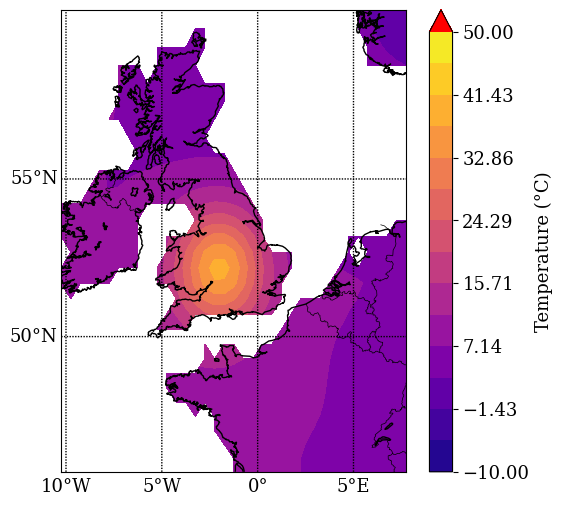

In [202]:
plot_temperature_map(df_test[df_test.time==df_test.time.unique()[-1]], vmin=-8, vmax=30, pred_col="tmp")
plot_temperature_map(df_stgp_last_month, vmin=-10, vmax=50, pred_col="pred", outliers_plot=False)

## Inference - ST-RCGP

In [205]:
rcgp_base_model = SpatioTemporalRCGP(ts=ts, grid=grid, Ys=Ys, p=1)

rcgp_base_model.activate_robustness(func="m_pred")
rcgp_base_model.adaptive_c()

params = pd.read_csv("RCGP_params.csv", index_col=0)
"""
rcgp_base_model.var_y = var_y
rcgp_base_model.temporal_lengthscale = lengthscale_time
rcgp_base_model.temporal_magnitude = magnitude_time
rcgp_base_model.spatial_lengthscale = lengthscale_space
rcgp_base_model.spatial_magnitude = magnitude_space
"""
rcgp_base_model.var_y = params.loc["var"].item()
rcgp_base_model.temporal_lengthscale = params.loc["tl"].item()
rcgp_base_model.temporal_magnitude = params.loc["tm"].item()
rcgp_base_model.spatial_lengthscale = params.loc["sl"].item()
rcgp_base_model.spatial_magnitude = params.loc["sm"].item()

with tc.no_grad():
    (preds_smooth_rcgp, stds_smooth_rcgp, eff_rcgp), (preds_filt_rcgp, covs_filt_rcgp, R_rcgp, Ws_norm_rcgp), (ms_rcgp, Ps_rcgp) = rcgp_base_model.forward(smoothing=True)

In [206]:
df_rcgp_train_month, df_rcgp_reg_month, df_rcgp_outlier_month, df_rcgp_last_month = get_rmse_nlpd(preds_smooth=preds_smooth_rcgp, stds_smooth=stds_smooth_rcgp)

Regular Month : 
NLPD :  1.2503815
RMSE :  0.88411283
Regular Month : 
NLPD :  3.5058892
RMSE :  1.5589168
Regular Month (Last Training Step) : 
NLPD :  1.5272976
RMSE :  0.97058874
Regular Month : 
NLPD :  2.4970014
RMSE :  1.2785071
Outlier Month : 
NLPD :  2.7957056
RMSE :  1.4591719
Prediction Month : 
NLPD :  4.075635
RMSE :  6.158125


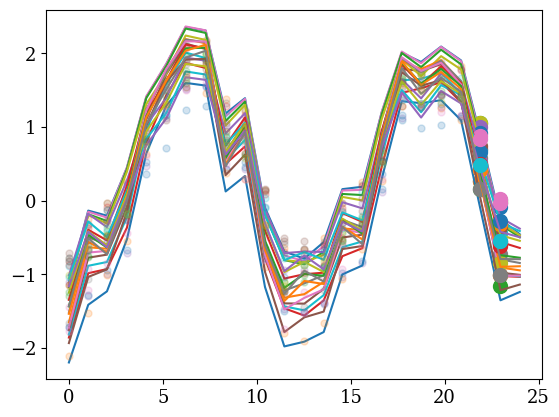

In [207]:
for i in range(20):
    plt.plot(ts, preds_smooth_rcgp[:, 10 * i], label="Pred")
    plt.plot(ts_train, Ys_train[:, 10 * i], '.', alpha=0.2, markersize=10, label="Train data")
    plt.plot(ts_test, Ys_test[:, 10 * i], '.', markersize=20, label="Test data")

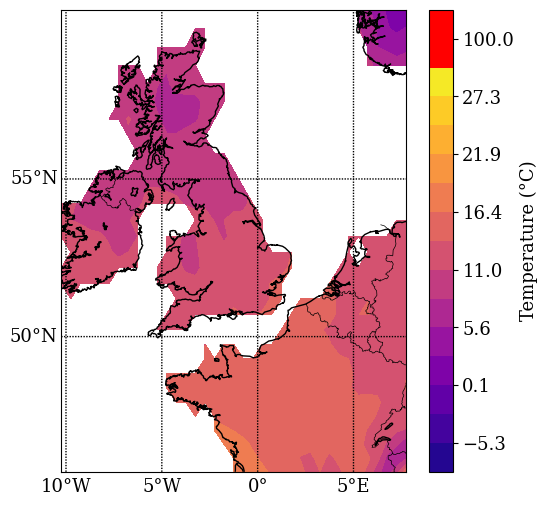

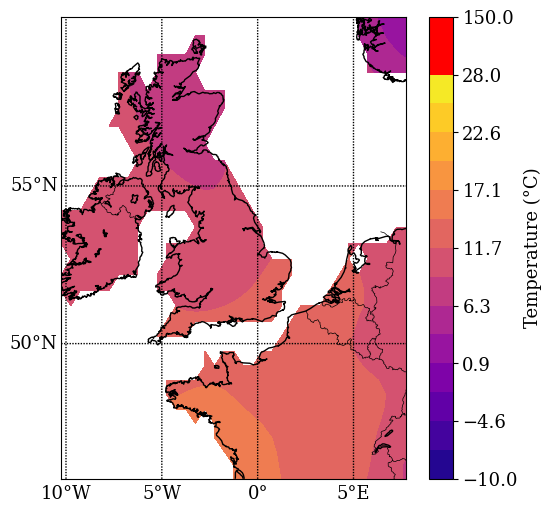

In [109]:
plot_temperature_map(df_test[df_test.time==df_test.time.unique()[-3]], vmin=-8, vmax=30, pred_col="tmp_data")
plot_temperature_map(df_rcgp_reg_month, vmin=-10, vmax=28, pred_col="pred")

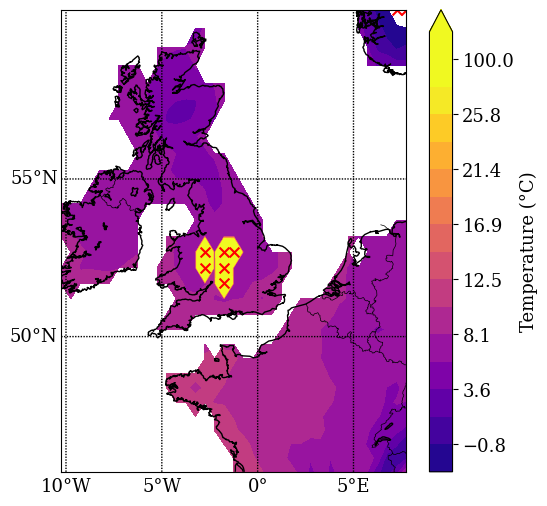

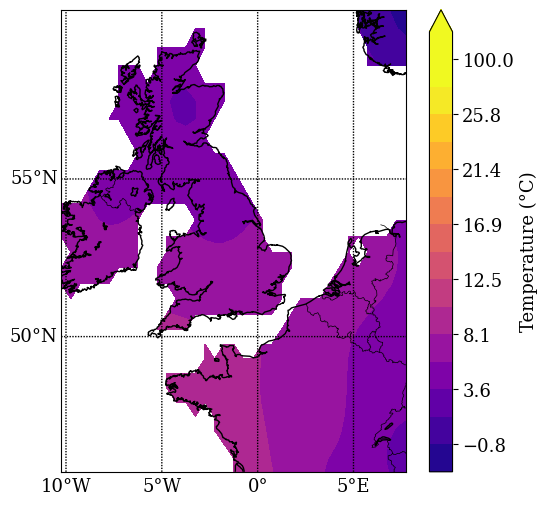

In [208]:
plot_temperature_map(df_test[df_test.time==df_test.time.unique()[-2]], vmin=-3, vmax=28, pred_col="tmp_data")
plot_temperature_map(df_rcgp_outlier_month, vmin=-3, vmax=28, pred_col="pred")

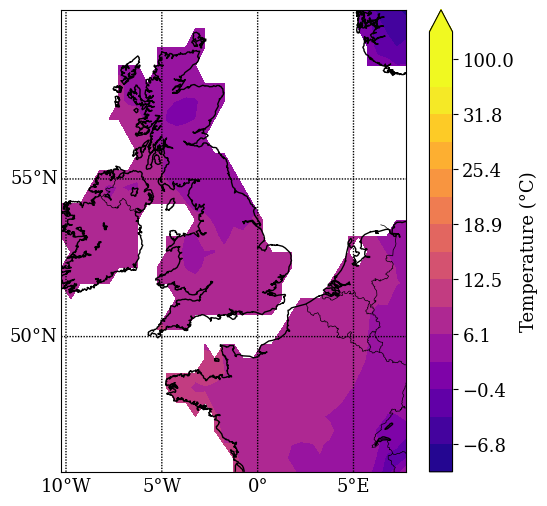

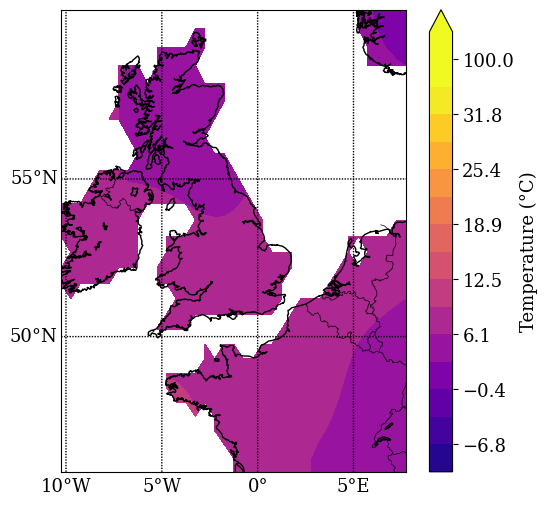

In [210]:
plot_temperature_map(df_test[df_test.time==df_test.time.unique()[-1]], vmin=-10, vmax=35, pred_col="tmp")
plot_temperature_map(df_rcgp_last_month, vmin=-10, vmax=35, pred_col="pred")